In [1]:
import dask.dataframe as dd
import dask.array as da
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error, r2_score

In [2]:
parq = glob.glob("big_processed_4.parquet/*.parquet")
ddf = dd.read_parquet(parq)

In [3]:
dd_train, dd_test = ddf.random_split([0.80, 0.2], random_state = 2019)

In [4]:
df = dd_train.compute()

In [5]:
neighbor_cols = [f'neighbor_{n}' for n in range(25)]
df[neighbor_cols] = pd.DataFrame(df.neighbors.values.tolist(), index= df.index)

In [6]:
# even though we imputed by timestamp in the spark file, some timestamps were wholly empty
mean_epa = df['imputed_epa_pm25_value'].mean()
df['imputed_epa_pm25_value'] = df['imputed_epa_pm25_value'].fillna(mean_epa)

In [7]:
df.shape

(9752724, 34)

In [10]:
df.isnull().any()

2_5um                     False
imputed_epa_pm25_value    False
imputed_hum               False
imputed_temperature       False
wind_x                    False
wind_y                    False
ndvi                      False
elevation                 False
neighbors                 False
neighbor_0                False
neighbor_1                False
neighbor_2                False
neighbor_3                False
neighbor_4                False
neighbor_5                False
neighbor_6                False
neighbor_7                False
neighbor_8                False
neighbor_9                False
neighbor_10               False
neighbor_11               False
neighbor_12               False
neighbor_13               False
neighbor_14               False
neighbor_15               False
neighbor_16               False
neighbor_17               False
neighbor_18               False
neighbor_19               False
neighbor_20               False
neighbor_21               False
neighbor

In [18]:
input_cols = [col for col in df.columns if col != "neighbors"]

In [20]:
df[input_cols].to_parquet("final_train_2.parquet")

In [21]:
import gc
del df
gc.collect()

2407

In [22]:
df = dd_test.compute()
df[neighbor_cols] = pd.DataFrame(df.neighbors.values.tolist(), index= df.index)
df['imputed_epa_pm25_value'] = df['imputed_epa_pm25_value'].fillna(mean_epa)
df.shape

(2440650, 34)

In [23]:
df[input_cols].to_parquet("final_test_2.parquet")

In [24]:
del df, ddf
gc.collect()

20

In [ ]:
# restart kernel, memory issues

In [2]:
train = dd.read_parquet("final_train_2.parquet")

In [3]:
# for today, just train it on ~1m rows
train_df = train.sample(frac = 0.103, random_state = 2019).compute()
train_df.shape

(1004531, 33)

In [4]:
neighbor_cols = [f'neighbor_{n}' for n in range(25)]
input_cols = ['imputed_epa_pm25_value', 'imputed_hum', 
              'imputed_temperature', 'wind_x','wind_y', 
              'ndvi', 'elevation'] + neighbor_cols

In [5]:


rf = RandomForestRegressor(n_estimators = 100)

In [9]:
%%time
rf.fit(train_df[input_cols], train_df['2_5um'])

CPU times: user 27min 27s, sys: 3.48 s, total: 27min 31s
Wall time: 27min 29s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [10]:
from joblib import dump, load
dump(rf, 'RF_20191208.joblib') 

['RF_20191208.joblib']

In [18]:
rf = load('RF_20191208.joblib')

In [16]:
test = dd.read_parquet("final_test.parquet")
test_df = test.sample(frac = 0.2, random_state = 1234).compute()
test_df.shape

(612710, 33)

In [19]:
test_df['pred'] = rf.predict(test_df[input_cols])

In [ ]:
mean_squared_error(test_df['2_5um'], test_df['pred'])**0.5

In [46]:
mean_squared_error(test_df['2_5um'], test_df['pred'])**0.5

5.923312563326653

In [47]:
r2_score(test_df['2_5um'], test_df['pred'])

0.7557488713698111

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

(0, 200)

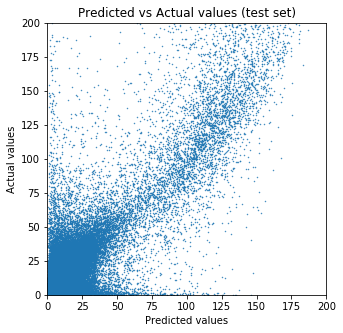

In [49]:
f, a = plt.subplots(figsize=(5,5))
a.scatter(test_df['pred'],test_df['2_5um'], s = 0.2)
a.set_title("Predicted vs Actual values (test set)")
a.set_ylabel("Actual values")
a.set_xlabel("Predicted values")
a.set_ylim(0,200)
a.set_xlim(0,200)
